# Testing for 1-dimensional, 2-species Schelling model dynamics

In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/code/uchicago/sociohydro/sim/Schelling1D2S`
Precompiling project...
  ✓ Schelling1D2S
  1 dependency successfully precompiled in 2 seconds. 197 already precompiled.


In [2]:
using Plots
using LaTeXStrings
using HDF5
using DSP
using StatsBase
using ProgressMeter
using Printf
using JSON
using LinearAlgebra
using Schelling1D2S
using ProfileVega

In [3]:
drivefolder = "/Users/danny/Google Drive/My Drive/uchicago/sociohydro/";

In [58]:
# function load_data(path; frac = 0)
#     # load data
#     files = searchdir(path, "hdf5")
#     params = JSON.parsefile(searchdir(path, "json")[1])
    
#     # only load from frac - finish
#     N_total = length(files)
#     N_saved = Int(floor(N_total * (1 - frac)))
    
#     state = Array{Int64}(undef, params["grid_size"])
#     ϕA_array = Array{Float64}(undef, params["grid_size"], N_saved)
#     ϕB_array = Array{Float64}(undef, params["grid_size"], N_saved)
#     x_array = collect(1:params["grid_size"])
#     t_array = Array{Float64}(undef, N_saved)
#     for (fidx, file) in enumerate(files[end-N_saved + 1:end])
#         h5open(file, "r") do d
#             state = read(d["data"], "state")
#             t_array[fidx] = read(d["data"], "sweep")
#         end
#         ϕA_array[:, fidx] = state[:, 1] ./ params["capacity"]
#         ϕB_array[:, fidx] = state[:, 2] ./ params["capacity"]
#     end
#     return ϕA_array, ϕB_array, x_array, t_array .* params["dt"], params
# end

function load_data(path)
    files = searchdir(path, "hdf5")
    params = JSON.parsefile(searchdir(path, "json")[1])

    x = collect(1:params["grid_size"])
    h5open(params["savepath"] * "/" * params["filename"], "r") do d
        groups = keys(d)
        ϕA = Array{Float64}(undef, params["grid_size"], length(groups))
        ϕB = Array{Float64}(undef, params["grid_size"], length(groups))
        t = Array{Float64}(undef, length(groups))
        for (gidx, g) in enumerate(groups)
            state = read(d[g], "state")
            ϕA[:, gidx] = state[:, 1]
            ϕB[:, gidx] = state[:, 2]
            t[gidx] = read(d[g], "sweep")
        end
        return ϕA ./ params["capacity"], ϕB ./ params["capacity"], x, t .* params["dt"], params
    end
end

searchdir(path,key) = filter(x->occursin(key,x), readdir(path, join=true))

searchdir (generic function with 1 method)

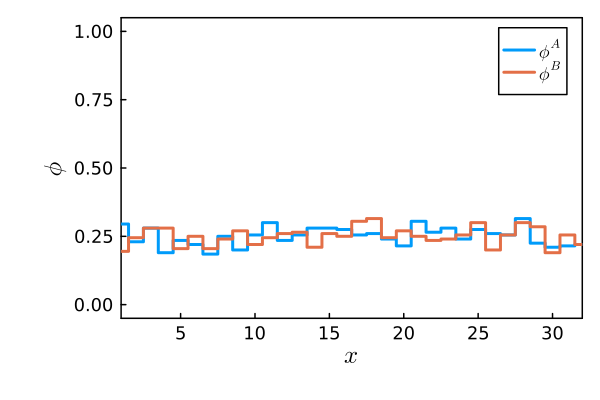

In [5]:
params = Dict("capacity" => 200,
              "dt" => 0.01,
              "n_sweeps" => 10000,
              "grid_size" => 32,
              "fill" => [0.25, 0.25],
              "snapshot" => 500,
              "temperature" => 0.1,
              "alpha" => 0.0,
              "delta" => 1.0,
              "kappa" => 0.0,
              "savepath" => drivefolder * "2023-08-01_schelling1D2STest",
              "filename" => "data.hdf5");

x = collect(1:params["grid_size"])
# random IC
state = random_state(params)
# Sinusoidal IC
# λ = params["grid_size"] / 2
# k = 2π / λ
# δϕ = 0.05 * params["capacity"]
# ϕ0 = params["capacity"] .* params["fill"] 
# pert = δϕ .* [sin.(k.*x) sin.(k .* x + 1.0 * π * ones(params["grid_size"]))]
# state = mapslices(x -> x .* ϕ0, ones(params["grid_size"], 2), dims=2)
# state = Int.(round.(state + pert))
# state = zeros(Int64, params["grid_size"], 2)
# state[100, :] = [params["capacity"] / 5, 0 * params["capacity"] / 5]


plot(x, state[:, 1] ./ params["capacity"],
     lw=2, label=L"\phi^A", seriestype=:stepmid)
plot!(x, state[:, 2] ./ params["capacity"],
     lw=2, label=L"\phi^B", seriestype=:stepmid)
plot!(thickness_scaling=1.5, framestyle=:box, grid=false)
ylims!(-0.05, 1.05)
xlims!(minimum(x), maximum(x))
ylabel!(L"\phi")
xlabel!(L"x")

In [6]:
# for f in readdir(params["savepath"], join=true) rm(f) end
# @time run_simulation!(state, params)
run_simulation!(state, params);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


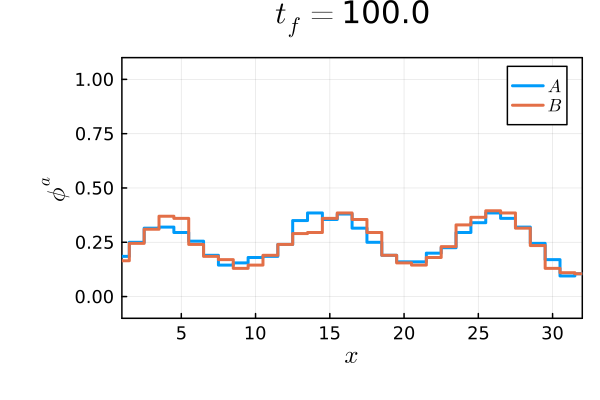

In [64]:
ϕA, ϕB, x, t, params = load_data(params["savepath"]);

p = plot(thickness_scaling=1.5, framestyle=:box,
         xlabel=L"x", ylabel=L"\phi^a",
         ylim=(-0.1, 1.1), xlim=(minimum(x), maximum(x)),
         title=L"t_f = " * string(t[end]))
plot!(x, ϕA[:, end], label=L"A", lw=2, seriestype=:stepmid)
plot!(x, ϕB[:, end], label=L"B", lw=2, seriestype=:stepmid)

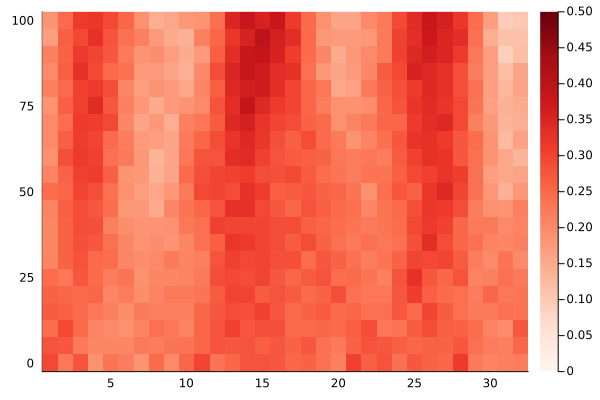

In [63]:
heatmap(x, t, transpose(ϕA), clim=(0, 0.5),
        cmap=:Reds)

[ Info: Saved animation to /Users/danny/code/uchicago/sociohydro/sim/Schelling1D2S/tmp.gif


Plots.AnimatedGif("/Users/danny/code/uchicago/sociohydro/sim/Schelling1D2S/tmp.gif")
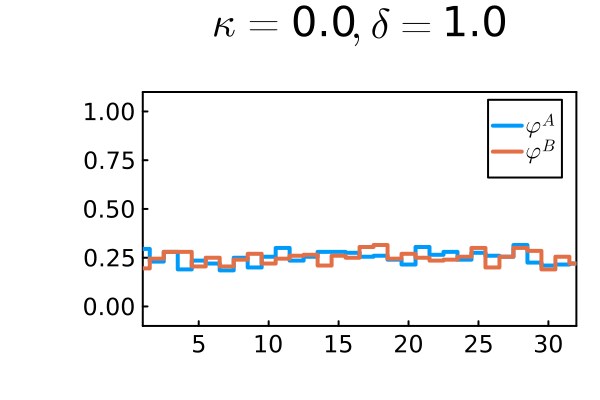

In [66]:
@gif for i in 1:2:length(t)
    plot(x, ϕA[:, i], lw=2, label=L"ϕ^A",
         seriestype=:stepmid)
    plot!(x, ϕB[:, i], lw=2, labels=L"ϕ^B",
          seriestype=:stepmid)
    plot!(framestyle=:box, grid=false, thickness_scaling=2)
    ylims!(-0.1, 1.1)
    xlims!(minimum(x), maximum(x))
    title!(L"\kappa = " * string(params["kappa"]) * L", \delta = " * string(params["delta"]))
end

# Diffusion test

without counting self as neighbor

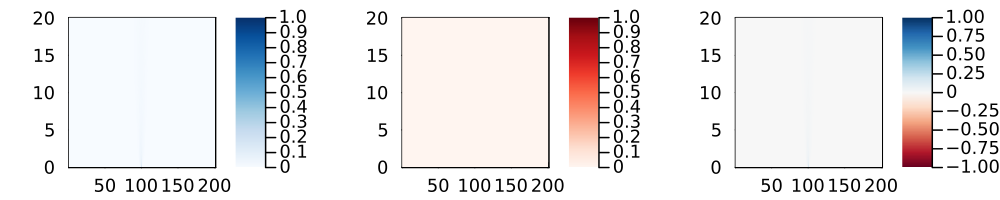

In [56]:
h1 = heatmap(x, t, transpose(ϕA), c=:Blues, clims=(0, 1))
h2 = heatmap(x, t, transpose(ϕB), c=:Reds, clims=(0, 1))
h3 = heatmap(x, t, transpose(ϕA - ϕB),
             color=:RdBu, clims=(-1, 1))
plot(h1, h2, h3, layout=(1, 3), size=(1000, 200))
plot!(framestyle=:box, thickness_scaling=1.5)

In [10]:
σA = zeros(Float64, length(t))
σB = zeros(Float64, length(t))
@showprogress for ii in 1:length(t)
    μxᴬ = sum(x .* ϕA[:, ii]) / sum(ϕA[:, ii])
    μxᴮ = sum(x .* ϕB[:, ii]) / sum(ϕB[:, ii])
    μxsqᴬ = sum(x.^2 .* ϕA[:, ii]) / sum(ϕA[:, ii])
    μxsqᴮ = sum(x.^2 .* ϕB[:, ii]) / sum(ϕB[:, ii])
    σA[ii] = sqrt(μxsqᴬ - μxᴬ^2)
    σB[ii] = sqrt(μxsqᴮ - μxᴮ^2)
end


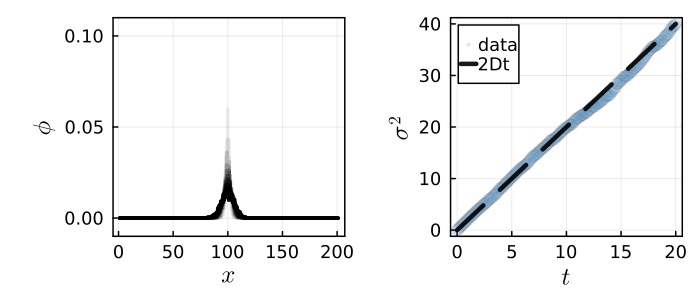

In [54]:
p1 = plot(thickness_scaling=1.5, framestyle=:box, xlabel=L"t", ylabel=L"\sigma^2")
plot!(t, σA.^2, marker=:o, lw=0, alpha=0.1, color=palette(:tab10)[1], label="data")
plot!(t, 2 * t * params["temperature"], ls=:dash, color=:black, lw=3, alpha=0.9, label="2Dt")

p2 = plot(ylim=(-0.01, 0.11), yticks=[0, 0.05, 0.1], xlabel=L"x", ylabel=L"\phi")
for tidx in 1:10:length(t)
    plot!(x, ϕA[:, tidx], lw=2, color=:black, alpha=tidx/length(t),
          label=L"\phi^A", seriestype=:stepmid, leg=false)
end

p = plot(p2, p1, layout=(1, 2), framestyle=:box, thickness_scaling=1.5, size=(700, 300))

savefig(p, "/Users/danny/Google Drive/My Drive/uchicago/adaptation/schelling/2023-07-07_schelling1D2S_diffusionTest.pdf")

display(p)

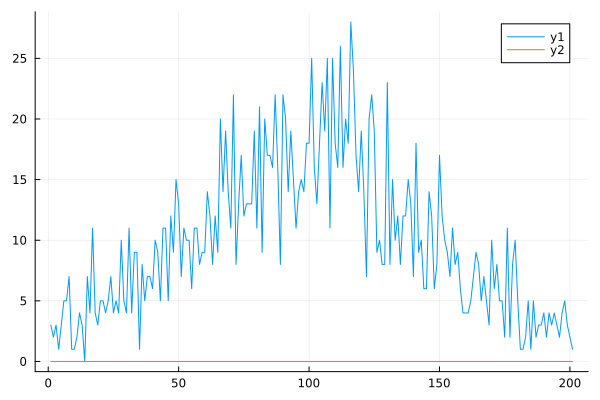

In [12]:
plot(x, state)

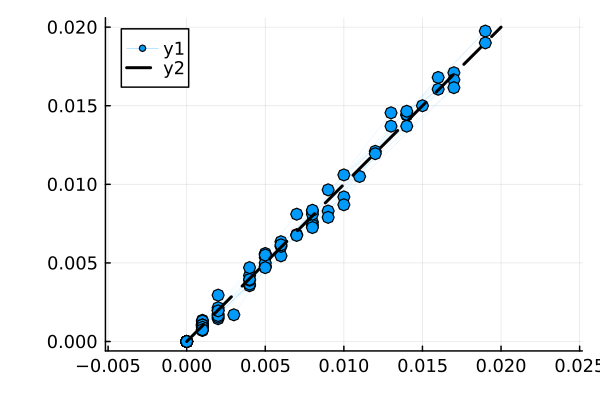

In [121]:
plot(state[53:141, 1] ./ params["capacity"] ,  h.weights / 2, lw=0, marker=:o)
plot!([0, 0.02], [0, 0.02], ls=:dash, lw=2, color=:black)
plot!(aspect_ratio=1, thickness_scaling=1.5)

In [77]:
length(h.weights)

89

with the factor of 2 in the transition rate

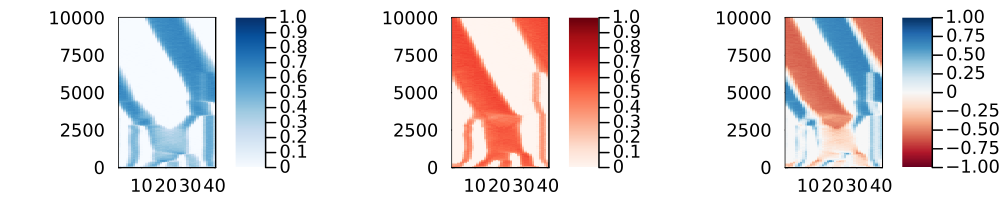

In [8]:
h1 = heatmap(x, t, transpose(ϕA), c=:Blues, clims=(0, 1))
h2 = heatmap(x, t, transpose(ϕB), c=:Reds, clims=(0, 1))
h3 = heatmap(x, t, transpose(ϕA - ϕB),
             color=:RdBu, clims=(-1, 1))
plot(h1, h2, h3, layout=(1, 3), size=(1000, 200))
plot!(framestyle=:box, thickness_scaling=1.5)

without the factor of 2 in the transition rate

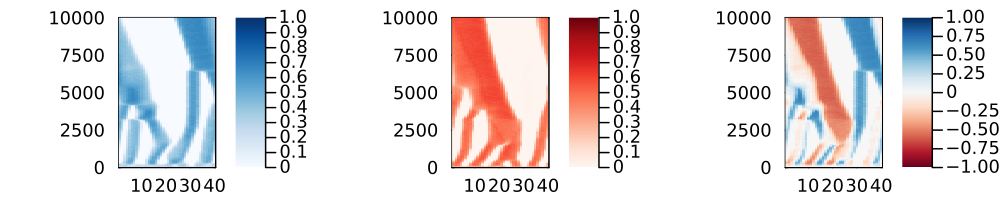

In [28]:
h1 = heatmap(x, t, transpose(ϕA), c=:Blues, clims=(0, 1))
h2 = heatmap(x, t, transpose(ϕB), c=:Reds, clims=(0, 1))
h3 = heatmap(x, t, transpose(ϕA - ϕB),
             color=:RdBu, clims=(-1, 1))
plot(h1, h2, h3, layout=(1, 3), size=(1000, 200))
plot!(framestyle=:box, thickness_scaling=1.5)

[ Info: Saved animation to /Users/danny/code/uchicago/adaptation/schelling/Schelling1D2S/tmp.gif


Plots.AnimatedGif("/Users/danny/code/uchicago/adaptation/schelling/Schelling1D2S/tmp.gif")
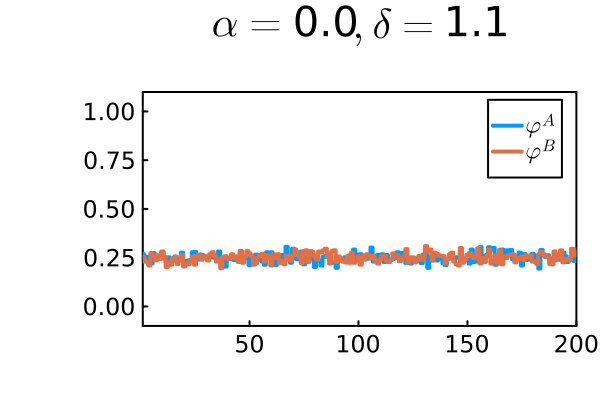

In [29]:
@gif for i in 1:10:length(t)
    plot(x, ϕA[:, i], lw=2, label=L"ϕ^A",
         seriestype=:stepmid)
    plot!(x, ϕB[:, i], lw=2, labels=L"ϕ^B",
          seriestype=:stepmid)
    plot!(framestyle=:box, grid=false, thickness_scaling=2)
    ylims!(-0.1, 1.1)
    xlims!(minimum(x), maximum(x))
    title!(L"\alpha = " * string(params["alpha"]) * L", \delta = " * string(params["delta"]))
end

Calculate Lyapunov Function

In [54]:
# entropy
S = entropy.(ϕA) + entropy.(ϕB) + entropy.(1 .- ϕA .- ϕB)

# global fitness
ua = similar(ϕA)
ub = similar(ϕB)
# link function
la = similar(ϕA)
lb = similar(ϕB)
for i in eachindex(ϕA)
    ua[i], ub[i] = quadratic_utility([ϕA[i], ϕB[i]], params["delta"])
    la[i] = 2 * 4 * (ϕA[i]^2 / 2 - ϕA[i]^3 / 3) + 4 * params["delta"] * ϕA[i] * ϕB[i] * (1 - ϕB[i])
    lb[i] = 2 * 4 * (ϕB[i]^2 / 2 - ϕB[i]^3 / 3) - 4 * params["delta"] * ϕB[i] * ϕA[i] * (1 - ϕA[i])
end
U = ϕA .* ua + ϕB .* ub
L = (la + lb) / 2

# gradient
N = params["grid_size"]
grad = diagm(-(N - 1) => -ones(1),
             -1 => -ones(N - 1),
             +1 => +ones(N - 1),
             +(N - 1) => ones(1)) / 2
∇ϕA_sq = (grad * ϕA).^2 ./ 2
∇ϕB_sq = (grad * ϕB).^2 ./ 2
grad = ∇ϕA_sq + ∇ϕB_sq

lyapunov = params["temperature"] * S + params["alpha"] * U + (1 - params["alpha"]) * L - grad;

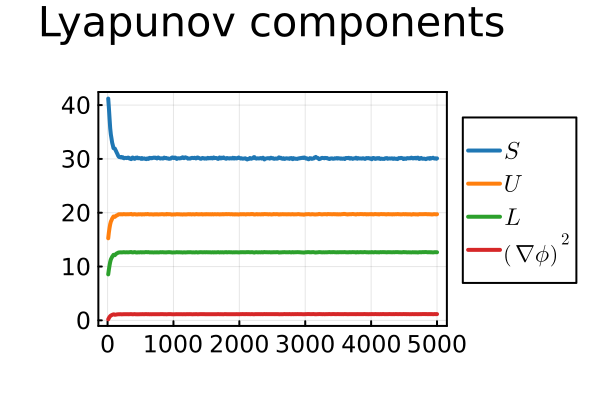

In [55]:
s = vec(sum(S, dims=1))
u = vec(sum(U, dims=1))
l = vec(sum(L, dims=1))
g = vec(sum(grad, dims=1))

plot(t, [s, u, l, g], title="Lyapunov components",
     label=[L"S" L"U" L"L" L"\left(\nabla \phi \right)^2"], thickness_scaling=2, lw=2, framestyle=:box,
     palette=:tab10)
plot!(legend=:outerright)

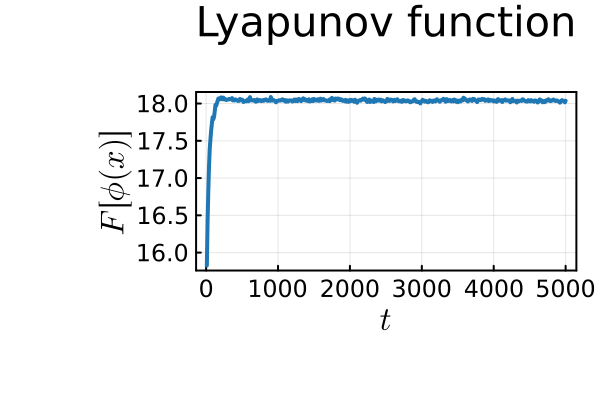

In [56]:
plot(t, vec(sum(lyapunov, dims=1)),
     framestyle=:box, lw=2, palette=:tab10,
     thickness_scaling=2, leg=false, title="Lyapunov function")
ylabel!(L"F[\phi(x)]")
xlabel!(L"t")

# Coarse-graining test

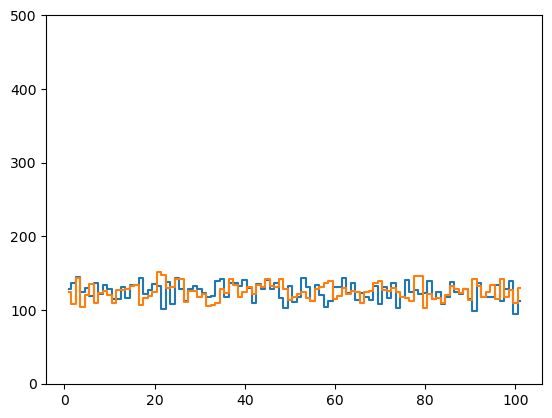

1-element Vector{Tuple{Float64, Float64}}:
 (-1.0, 501.0)

In [5]:
params = Dict("capacity" => 500,
              "temperature" => 0.1,
              "preferred_density" => 0.5,
              "m" => 0.0,
              "alpha" => 0.0,
              "n_sweeps" => 250,
              "moveType" => "local",
              "grid_size" => 101,
              "fill" => [0.25, 0.25],
              "utility_func" => quadratic_utility,
              "snapshot" => 2,
              "delta" => 1.0,
              "kernel_size" => 11,
              "savepath" => drivefolder * "2023-05-02_1D2S_cgTest");

state = random_state(params)
# state = 125 .* ones(Int64, params["grid_size"], 2)
# state = zeros(Int64, params["grid_size"], 2)
# state[20, 1] = 400
# state[80, 2] = 400

fig, ax = plt.subplots()
ax.plot(1:params["grid_size"], state, drawstyle="steps-mid")
ax.set(ylim=[-1, params["capacity"] + 1])

In [52]:
run_simulation!(state, params);

Progress: 100%|█████████████████████████████████████████| Time: 0:07:12


In [6]:
run_simulation!(state, params);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:16


In [7]:
files = readdir(params["savepath"], join=true)[2:end]
state = zeros(Int64, params["grid_size"], 2, length(files))
for (idx, file) in enumerate(files)
    c = h5open(file, "r") do d
        state[:, :, idx] = read(d, "data/state")
    end
end


$\delta = 1$, $L_{kernel} = 1$, $T = 0.1$

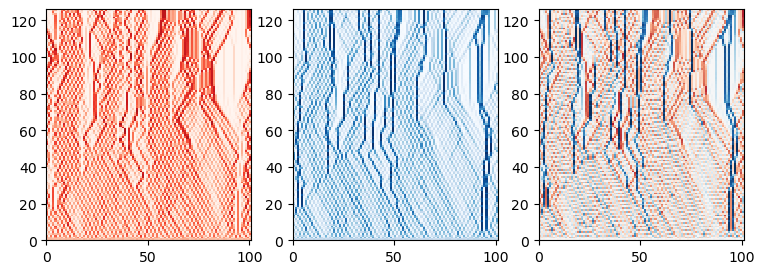

PyObject <matplotlib.collections.QuadMesh object at 0x17900dd90>

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[1].pcolormesh(transpose(state[:, 1, :]), vmin=0, vmax=params["capacity"], cmap="Reds")
ax[2].pcolormesh(transpose(state[:, 2, :]), vmin=0, vmax=params["capacity"], cmap="Blues")
ax[3].pcolormesh(transpose(state[:, 1, :] - state[:, 2, :]), vmin=-params["capacity"], vmax=params["capacity"], cmap="RdBu_r")

$\delta = 1$, $L_{kernel} = 7$, $T = 0.1$

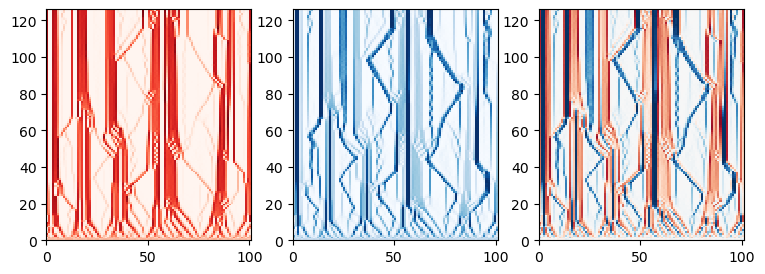

PyObject <matplotlib.collections.QuadMesh object at 0x1783d6220>

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[1].pcolormesh(transpose(state[:, 1, :]), vmin=0, vmax=params["capacity"], cmap="Reds")
ax[2].pcolormesh(transpose(state[:, 2, :]), vmin=0, vmax=params["capacity"], cmap="Blues")
ax[3].pcolormesh(transpose(state[:, 1, :] - state[:, 2, :]), vmin=-params["capacity"], vmax=params["capacity"], cmap="RdBu_r")

$\delta = 1$, $L_{kernel} = 11$, $T = 0.1$

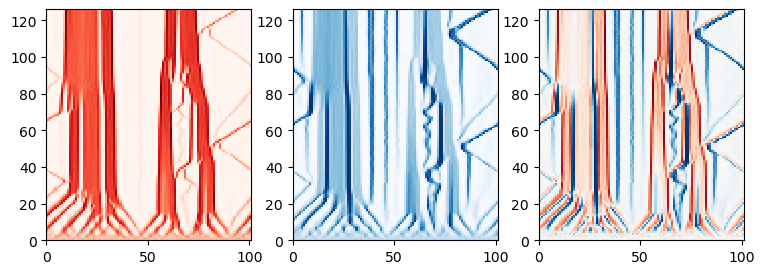

PyObject <matplotlib.collections.QuadMesh object at 0x178562f70>

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[1].pcolormesh(transpose(state[:, 1, :]), vmin=0, vmax=params["capacity"], cmap="Reds")
ax[2].pcolormesh(transpose(state[:, 2, :]), vmin=0, vmax=params["capacity"], cmap="Blues")
ax[3].pcolormesh(transpose(state[:, 1, :] - state[:, 2, :]), vmin=-params["capacity"], vmax=params["capacity"], cmap="RdBu_r")

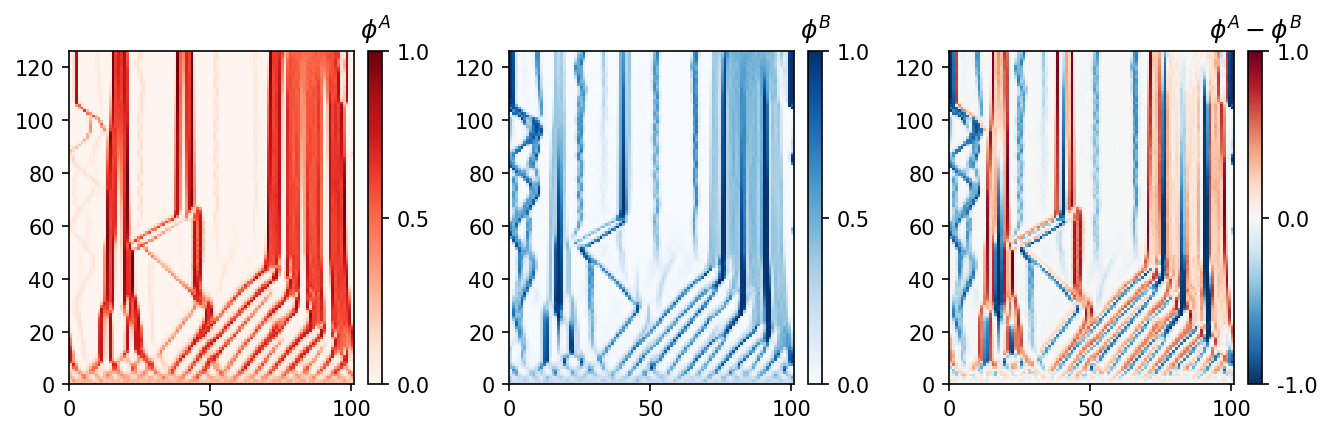

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)

a1 = ax[1].pcolormesh(transpose(state[:, 1, :]), vmin=0, vmax=params["capacity"], cmap="Reds", rasterized=true)
cax1 = ax[1].inset_axes([1.05, 0.0, 0.05, 1])
cbar = fig.colorbar(a1, cax=cax1, ax=ax[1], ticks=[0, 250, 500])
cbar.ax.set(title=L"$\phi^A$", yticklabels=["0.0", "0.5", "1.0"])

a2 = ax[2].pcolormesh(transpose(state[:, 2, :]), vmin=0, vmax=params["capacity"], cmap="Blues", rasterized=true)
cax2 = ax[2].inset_axes([1.05, 0.0, 0.05, 1])
cbar = fig.colorbar(a2, cax=cax2, ax=ax[2], ticks=[0, 250, 500])
cbar.ax.set(title=L"$\phi^B$", yticklabels=["0.0", "0.5", "1.0"])


a3 = ax[3].pcolormesh(transpose(state[:, 1, :] - state[:, 2, :]), vmin=-params["capacity"], vmax=params["capacity"], cmap="RdBu_r", rasterized=true)
cax3 = ax[3].inset_axes([1.05, 0.0, 0.05, 1])
cbar = fig.colorbar(a3, cax=cax3, ax=ax[3], ticks=[-500, 0, 500])
cbar.ax.set(title=L"$\phi^A  - \phi^B$", yticklabels=["-1.0", "0.0", "1.0"])


plt.tight_layout()
fig.savefig(drivefolder * "2023-05-02_1D2S_kernel11_delta1_alpha0_kymo.pdf", bbox_inches="tight")

sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator


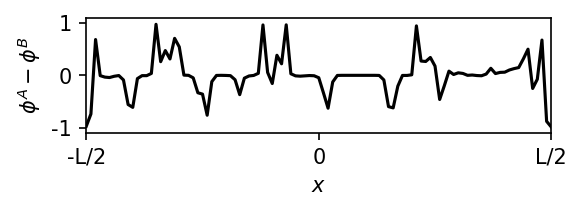

In [109]:
moviefolder = drivefolder * "/2023-05-02_1D2S_kernel11_delta1_alpha0_movie"

fig, ax = plt.subplots(dpi=150, figsize=(4, 1))
for tidx in 1:size(state)[3]
    ax.cla()
    ax.plot(-50:50, state[:, 1, tidx], color="C3")
    ax.plot(-50:50, state[:, 2, tidx], color="C0")
    ax.set(ylim=[-550, 550], xlim=[-50, 50],
           yticks=[-params["capacity"], 0, params["capacity"]],
           xticks=[-50,0,50],
           yticklabels=["-1", "0", "1"], xticklabels=["-L/2", "0", "L/2"],
           ylabel=L"$\phi^A - \phi^B$", xlabel=L"$x$")
    savename = @sprintf("%03d", tidx)
    fig.savefig(moviefolder * "/t" * savename * ".png", bbox_inches="tight")
end

In [137]:
qu(x) = quadratic_utility(x, params)
fitness = [mapslices(qu, state[:, :, tidx] ./ params["capacity"], dims=2) for tidx in 1:size(state)[3]];

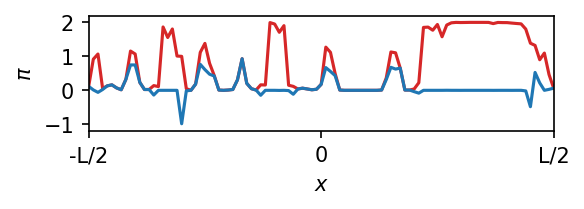

In [136]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 1))
for (tidx, f) in enumerate(fitness)
    ax.cla()
    ax.plot(-50:50, f[:, 1], color="C3")
    ax.plot(-50:50, f[:, 2], color="C0")
    ax.set(ylim=[-1.2, 2.2], xlim=[-50, 50],
           yticks=[-1, 0, 1, 2],
           xticks=[-50,0,50],
           xticklabels=["-L/2", "0", "L/2"],
           ylabel=L"$\pi$", xlabel=L"$x$")
    savename = @sprintf("%03d", tidx)
    fig.savefig(moviefolder * "/t" * savename * ".png", bbox_inches="tight")
end

In [5]:
function local_average(arr::Vector{Int}, site::Int, box_size::Int)
    kernel = Windows.gaussian(box_size, 0.1) # create kernel
    kernel /= sum(kernel)  # normalize kernel
    half_box = Int(floor(box_size / 2))
    arr_periodic = cat(arr[end-half_box+1:end], arr, arr[1:half_box], dims=1)
    
    psite = half_box + site
    
    c = sum(arr_periodic[psite - half_box:psite + half_box] .* kernel)

    return c
end

function local_average(arr::Matrix{Int}, site::Int, box_size::Int; dims::Int)
    la(x) = local_average(x, site, box_size)
    c = mapslices(la, arr, dims=dims)
    return c
end

local_average (generic function with 2 methods)

In [7]:
arr = state[:, 1]
site = 20
box_size = 7
kernel = Windows.gaussian(box_size, 0.1) # create kernel
kernel /= sum(kernel)  # normalize kernel
half_box = Int(floor(box_size / 2))
arr_periodic = cat(arr[end-half_box+1:end], arr, arr[1:half_box], dims=1)
psite = half_box + site
arr_periodic[psite - half_box:psite + half_box]

7-element Vector{Int64}:
 121
 131
 127
 134
 150
 118
 128

In [11]:
site = 40
psite = half_box + site
println(size(state[site, :]))
println(size(transpose(local_average(state, site, params["kernel_size"], dims=1))))

(2,)
(2, 1)


In [12]:
state[site, :]

2-element Vector{Int64}:
 114
 139

In [16]:
vec(local_average(state, site, params["kernel_size"], dims=1))

2-element Vector{Float64}:
 118.0264226691195
 129.52873318037197